In [27]:
import geopandas as gpd
import pandas as pd
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import os
import osmnx as ox
import warnings
warnings.filterwarnings('ignore')

In [28]:
os.getcwd()

'G:\\OneDrive\\casa0010dissertation\\00_06 jaipur code'

In [29]:
os.chdir("G:/OneDrive/casa0010dissertation/00_06 jaipur code")

# 1 Load Jaipur GeoJSON

In [5]:
bound = gpd.read_file('data/raw/JMC_union.geojson')

<Axes: >

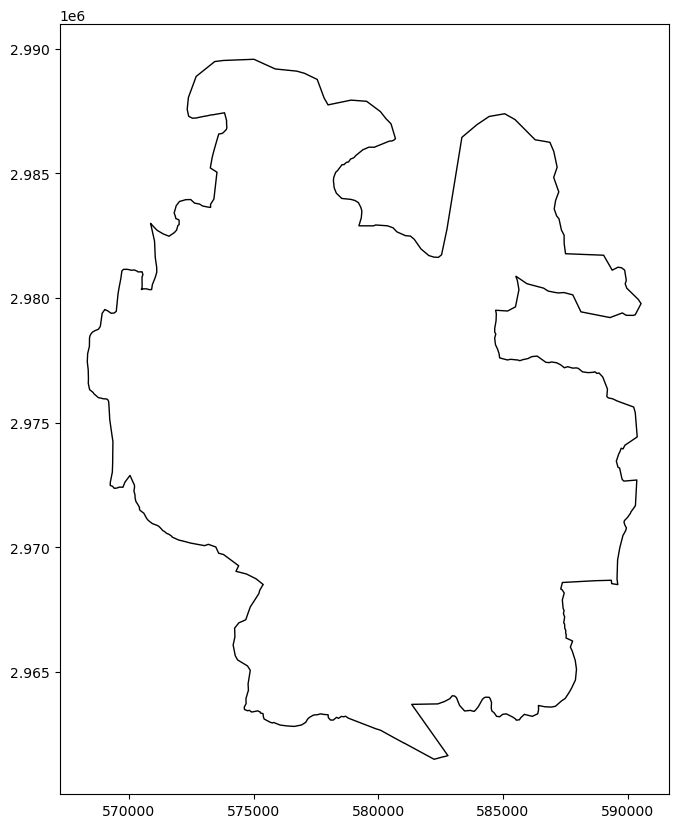

In [6]:
bound.plot(figsize=(10, 10), edgecolor='black', facecolor='none')

# 2 Load Jaipur POI

In [7]:
# Cell: Create bounding box and download POIs (Corrected)
print("Creating bounding box around the boundary...")
print(f"Original CRS: {bound.crs}")

# Convert from EPSG:32643 (UTM 43N) to EPSG:4326 (WGS84) for osmnx
print("Converting from EPSG:32643 to EPSG:4326...")
bound_wgs84 = bound.to_crs('EPSG:4326')
print("CRS conversion completed")

# Get the bounding box coordinates
bbox = bound_wgs84.total_bounds  # Returns [minx, miny, maxx, maxy]
west, south, east, north = bbox  # Rename for clarity

print(f"Bounding box coordinates:")
print(f"  West (left): {west:.6f}")
print(f"  South (bottom): {south:.6f}")
print(f"  East (right): {east:.6f}")
print(f"  North (top): {north:.6f}")

# Add some buffer to the bounding box
buffer_deg = 0.001  # About 100m buffer at equator
west_buffered = west - buffer_deg
south_buffered = south - buffer_deg
east_buffered = east + buffer_deg
north_buffered = north + buffer_deg

print(f"\nWith buffer ({buffer_deg} degrees):")
print(f"  Buffered west: {west_buffered:.6f}")
print(f"  Buffered south: {south_buffered:.6f}")
print(f"  Buffered east: {east_buffered:.6f}")
print(f"  Buffered north: {north_buffered:.6f}")

Creating bounding box around the boundary...
Original CRS: EPSG:32643
Converting from EPSG:32643 to EPSG:4326...
CRS conversion completed
Bounding box coordinates:
  West (left): 75.688148
  South (bottom): 26.772430
  East (right): 75.912046
  North (top): 27.026363

With buffer (0.001 degrees):
  Buffered west: 75.687148
  Buffered south: 26.771430
  Buffered east: 75.913046
  Buffered north: 27.027363



OSMnx bbox format (west, south, east, north): (np.float64(75.68714843273224), np.float64(26.771430236039777), np.float64(75.91304602633096), np.float64(27.02736257307409))


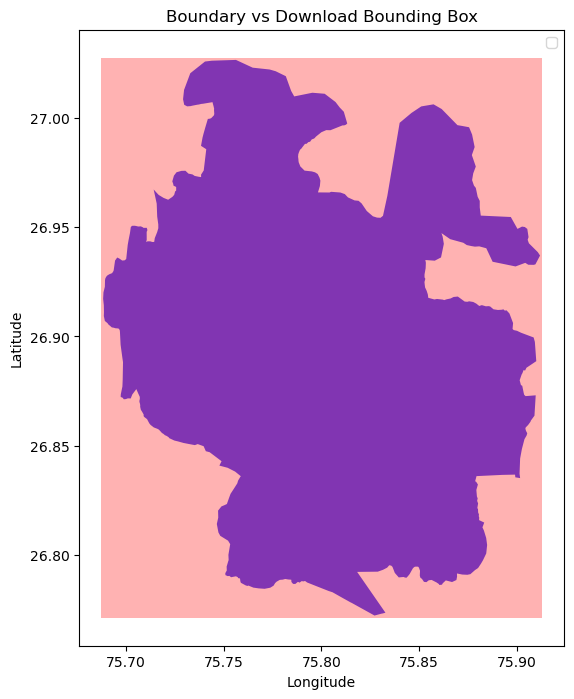

In [8]:
# osmnx bbox format is (left, bottom, right, top) = (west, south, east, north)
bbox_osmnx = (west_buffered, south_buffered, east_buffered, north_buffered)

print(f"\nOSMnx bbox format (west, south, east, north): {bbox_osmnx}")

# Visualize the bounding box (optional)
try:
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))

    # Plot original boundary
    bound_wgs84.plot(ax=ax, color='blue', alpha=0.7, label='Original Boundary')

    # Plot bounding box
    from shapely.geometry import box
    bbox_geom = box(west_buffered, south_buffered, east_buffered, north_buffered)
    bbox_gdf = gpd.GeoDataFrame([1], geometry=[bbox_geom], crs='EPSG:4326')
    bbox_gdf.plot(ax=ax, color='red', alpha=0.3, label='Download Bounding Box')

    ax.legend()
    ax.set_title('Boundary vs Download Bounding Box')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

except:
    print("Could not create visualization (matplotlib might not be available)")

In [9]:
# Cell 2: Define POI categories and boundary
# Define the 8 POI categories
poi_categories = {
    'sustenance': ['pub', 'bar', 'restaurant', 'biergarten', 'cafe', 'fast_food', 'food_court', 'ice_cream'],
    'education': ['kindergarten', 'college', 'library', 'school', 'university', 'training'],
    'transportation': ['bicycle_parking', 'bicycle_repair_station', 'bicycle_wash', 'bicycle_rental',
                      'parking_space', 'parking_entrance', 'parking', 'motorcycle_parking', 'fuel',
                      'charging_station', 'vehicle_inspection', 'car_wash', 'car_sharing', 'car_rental', 'bus_station'],
    'financial': ['atm', 'payment_terminal', 'bank', 'bureau_de_change', 'money_transfer', 'payment_centre'],
    'healthcare': ['baby_hatch', 'clinic', 'dentist', 'doctors', 'hospital', 'nursing_home',
                   'pharmacy', 'social_facility', 'veterinary'],
    'entertainment': ['arts_centre', 'brothel', 'casino', 'cinema', 'community_centre', 'conference_centre',
                      'events_venue', 'exhibition_centre', 'fountain', 'gambling', 'love_hotel', 'music_venue',
                      'nightclub', 'planetarium', 'public_bookcase', 'social_centre', 'stage', 'stripclub',
                      'studio', 'swingerclub', 'theatre'],
    'public_service': ['courthouse', 'fire_station', 'police', 'post_box', 'post_depot', 'post_office',
                       'prison', 'ranger_station', 'townhall'],
    'facilities': ['bbq', 'bench', 'dog_toilet', 'dressing_room', 'drinking_water', 'give_box',
                   'lounge', 'mailroom', 'parcel_locker', 'shelter', 'shower', 'telephone',
                   'toilets', 'water_point', 'watering_place']
}

In [10]:
# Cell 3: Main download function with loop
# Updated download function using correct bbox format
def download_poi_categories_bbox(bbox, poi_categories):
    """
    Download POI data for all categories using bounding box

    Parameters:
    bbox: Tuple of (west, south, east, north) coordinates in EPSG:4326
    poi_categories: Dictionary of categories and their amenity types

    Returns:
    poi_data: Dictionary containing POI data for each category
    """
    poi_data = {}

    print("\nStarting POI data download using bounding box...")
    print(f"Bbox: West={bbox[0]:.4f}, South={bbox[1]:.4f}, East={bbox[2]:.4f}, North={bbox[3]:.4f}")
    print(f"Total categories to download: {len(poi_categories)}")

    # Loop through each category
    for category, amenities in poi_categories.items():
        print(f"\n--- Downloading {category.upper()} POIs ---")

        # Create tags dictionary for this category
        tags = {'amenity': amenities}

        try:
            # Download POI data using OSMnx bbox method
            # bbox format: (west, south, east, north)
            category_pois = ox.features.features_from_bbox(bbox, tags)

            if not category_pois.empty:
                # Add category column
                category_pois['category'] = category
                poi_data[category] = category_pois
                print(f"  Successfully downloaded {len(category_pois)} {category} POIs")

                # Show breakdown by amenity type
                if 'amenity' in category_pois.columns:
                    amenity_counts = category_pois['amenity'].value_counts()
                    for amenity, count in amenity_counts.head(3).items():  # Show top 3
                        print(f"    {amenity}: {count}")
                    if len(amenity_counts) > 3:
                        print(f"    ... and {len(amenity_counts) - 3} more types")
            else:
                print(f"  No POIs found for {category}")
                poi_data[category] = gpd.GeoDataFrame()

        except Exception as e:
            print(f"  Error downloading {category} POIs: {str(e)}")
            poi_data[category] = gpd.GeoDataFrame()

    return poi_data

# Execute the bbox download function
poi_data = download_poi_categories_bbox(bbox_osmnx, poi_categories)


Starting POI data download using bounding box...
Bbox: West=75.6871, South=26.7714, East=75.9130, North=27.0274
Total categories to download: 8

--- Downloading SUSTENANCE POIs ---
  Successfully downloaded 369 sustenance POIs
    restaurant: 178
    cafe: 99
    fast_food: 62
    ... and 3 more types

--- Downloading EDUCATION POIs ---
  Successfully downloaded 122 education POIs
    school: 68
    college: 32
    library: 11
    ... and 2 more types

--- Downloading TRANSPORTATION POIs ---
  Successfully downloaded 248 transportation POIs
    parking: 116
    fuel: 95
    bus_station: 14
    ... and 7 more types

--- Downloading FINANCIAL POIs ---
  Successfully downloaded 174 financial POIs
    atm: 105
    bank: 69

--- Downloading HEALTHCARE POIs ---
  Successfully downloaded 872 healthcare POIs
    hospital: 423
    clinic: 306
    doctors: 53
    ... and 4 more types

--- Downloading ENTERTAINMENT POIs ---
  Successfully downloaded 74 entertainment POIs
    fountain: 19
    cin

## 2.1 Visualize POI Data in bbox

In [11]:
import matplotlib.pyplot as plt
import numpy as np


# Cell: Simple strict POI filtering (core code)

# Get boundary geometry
boundary_geom = bound.geometry.iloc[0]

# Strictly filter POIs for each category
poi_data_filtered = {}

print("Filtering POIs within boundary...")
for category, pois in poi_data.items():
    if pois.empty:
        poi_data_filtered[category] = pois
        continue

    # Convert to same coordinate system
    if pois.crs != bound.crs:
        pois_aligned = pois.to_crs(bound.crs)
    else:
        pois_aligned = pois.copy()

    # Strict filtering: keep only points completely within boundary
    within_mask = pois_aligned.geometry.within(boundary_geom)
    pois_filtered = pois_aligned[within_mask].copy()

    poi_data_filtered[category] = pois_filtered
    print(f"{category}: {len(pois)} -> {len(pois_filtered)} POIs")

# Update final data
final_poi_data = poi_data_filtered

# Quick verification check
print("\nQuick verification check:")
for category, pois in final_poi_data.items():
    if not pois.empty:
        # Check if any POIs are still outside boundary
        outside_count = sum(~pois.geometry.within(boundary_geom))
        if outside_count > 0:
            print(f"⚠️ {category}: {outside_count} POIs still outside!")
        else:
            print(f"✅ {category}: All {len(pois)} POIs within boundary")

print(f"\nTotal filtered POIs: {sum(len(pois) for pois in final_poi_data.values())}")

Filtering POIs within boundary...
sustenance: 369 -> 362 POIs
education: 122 -> 108 POIs
transportation: 248 -> 236 POIs
financial: 174 -> 170 POIs
healthcare: 872 -> 828 POIs
entertainment: 74 -> 70 POIs
public_service: 37 -> 36 POIs
facilities: 100 -> 94 POIs

Quick verification check:
✅ sustenance: All 362 POIs within boundary
✅ education: All 108 POIs within boundary
✅ transportation: All 236 POIs within boundary
✅ financial: All 170 POIs within boundary
✅ healthcare: All 828 POIs within boundary
✅ entertainment: All 70 POIs within boundary
✅ public_service: All 36 POIs within boundary
✅ facilities: All 94 POIs within boundary

Total filtered POIs: 1904


In [12]:
# Define colors for each category
category_colors = {
    'sustenance': '#FF6B6B',      # Red
    'education': '#4ECDC4',       # Teal
    'transportation': '#45B7D1',  # Blue
    'financial': '#96CEB4',       # Green
    'healthcare': '#FFEAA7',      # Yellow
    'entertainment': '#DDA0DD',   # Plum
    'public_service': '#FFB347',  # Orange
    'facilities': '#98D8C8'       # Mint
}

# Method 1: Individual plots for each category (8 subplots) in UTM
def plot_individual_categories_utm(poi_data_utm, boundary_gdf, category_colors):
    """
    Plot each POI category in separate subplots using UTM coordinates
    """
    # Filter out empty categories
    valid_categories = {k: v for k, v in poi_data_utm.items() if not v.empty}

    if not valid_categories:
        print("No POI data to plot!")
        return

    # Calculate subplot layout
    n_cats = len(valid_categories)
    cols = 3
    rows = int(np.ceil(n_cats / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)  # Make sure it's 2D

    # Plot each category
    for idx, (category, pois) in enumerate(valid_categories.items()):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]

        # Plot boundary in UTM coordinates
        boundary_gdf.plot(ax=ax, color='lightgray', alpha=0.5, edgecolor='black', linewidth=2)

        # Plot POIs in UTM coordinates
        if not pois.empty:
            pois.plot(ax=ax, color=category_colors[category], markersize=25, alpha=0.8)

        ax.set_title(f'{category.upper()}\n{len(pois)} POIs', fontsize=12, fontweight='bold')
        ax.set_xlabel('Easting (m)')
        ax.set_ylabel('Northing (m)')
        ax.grid(True, alpha=0.3)

        # Format axis labels for UTM coordinates
        ax.ticklabel_format(style='scientific', axis='both', scilimits=(0,0))

    # Hide empty subplots
    for idx in range(n_cats, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].set_visible(False)

    plt.tight_layout()
    plt.suptitle('POI Categories Distribution (UTM 43N - EPSG:32643)', fontsize=16, fontweight='bold', y=1.02)
    plt.show()


1. Individual category plots (UTM):


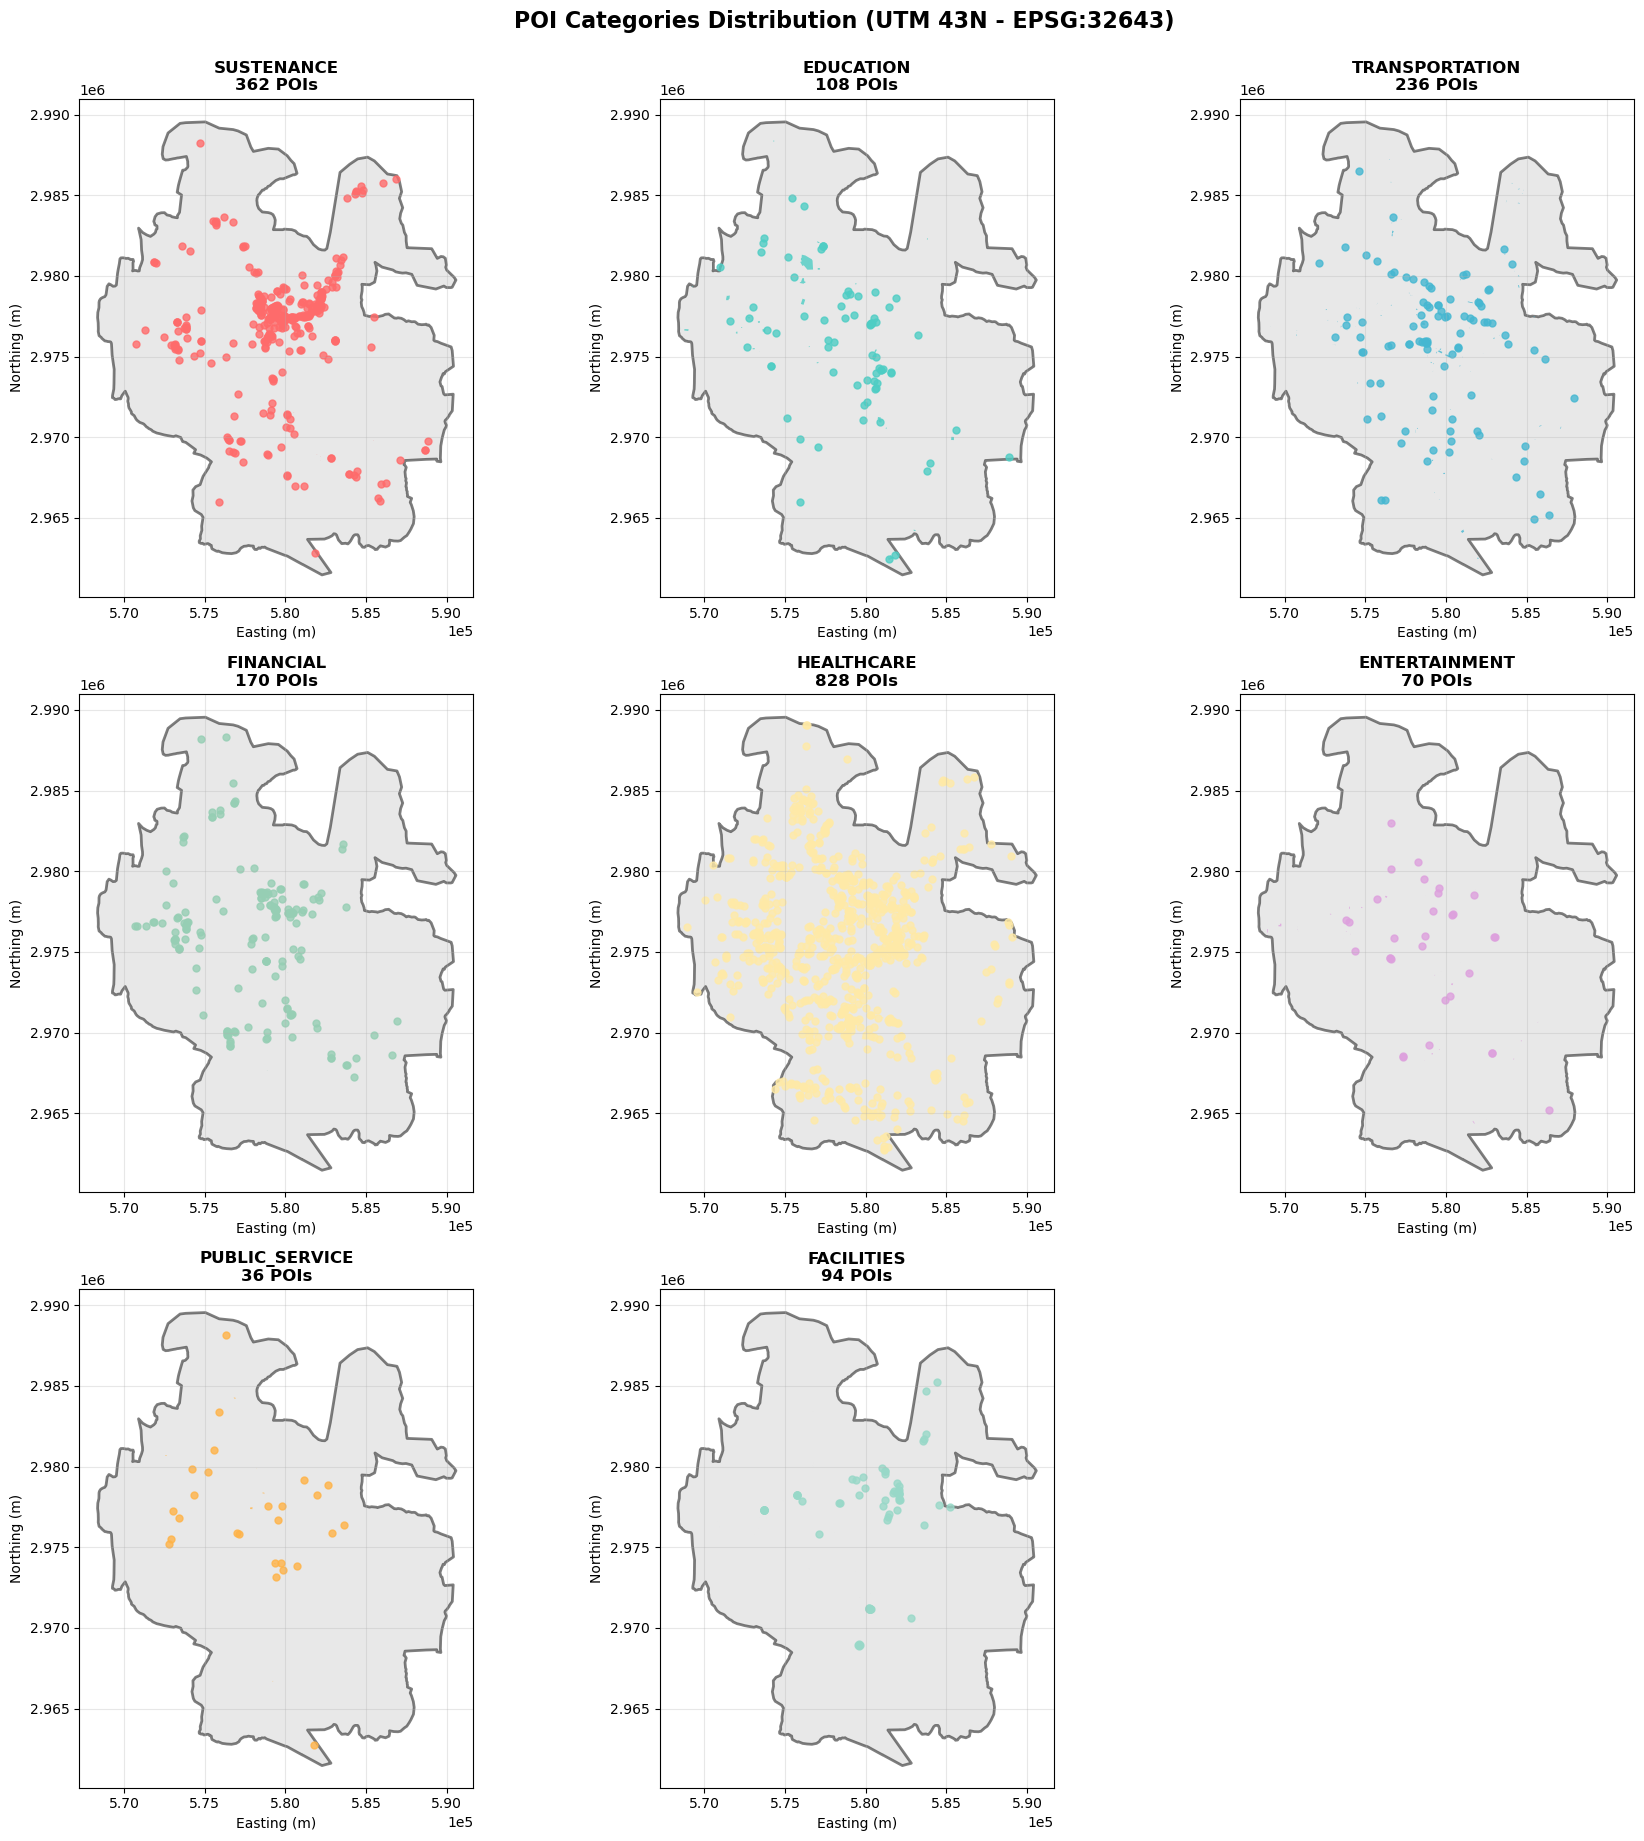

In [13]:
print("\n1. Individual category plots (UTM):")
plot_individual_categories_utm(final_poi_data, bound, category_colors)

In [15]:
# Cell: Export final POI data as single GeoDataFrame (GeoJSON only)
import pandas as pd
import os

def combine_and_export_poi_data(poi_data_dict, filename_base="all_pois"):
    """
    Combine all POI categories into single GeoDataFrame and export

    Parameters:
    poi_data_dict: Dictionary of POI GeoDataFrames by category
    filename_base: Base filename for export (without extension)

    Returns:
    combined_gdf: Single GeoDataFrame with all POIs
    """

    print("Combining POI data from all categories...")

    # Filter out empty categories
    valid_categories = {k: v for k, v in poi_data_dict.items() if not v.empty}

    if not valid_categories:
        print("No POI data to export!")
        return None

    # Combine all categories into single GeoDataFrame
    combined_dfs = []
    category_summary = []

    for category, pois in valid_categories.items():
        # Make sure each POI has category and poi_type columns
        pois_copy = pois.copy()

        # Add POI type columns
        pois_copy['poi_category'] = category

        # Use existing amenity column as poi_type, or category if amenity not available
        if 'amenity' in pois_copy.columns:
            pois_copy['poi_type'] = pois_copy['amenity']
        else:
            pois_copy['poi_type'] = category

        combined_dfs.append(pois_copy)
        category_summary.append(f"{category}: {len(pois)} POIs")
        print(f"  {category}: {len(pois)} POIs")

    # Concatenate all DataFrames
    combined_gdf = pd.concat(combined_dfs, ignore_index=True)

    print(f"\nCombined GeoDataFrame created:")
    print(f"  Total POIs: {len(combined_gdf)}")
    print(f"  Coordinate system: {combined_gdf.crs}")
    print(f"  Columns: {list(combined_gdf.columns)}")

    # Show POI type distribution
    print(f"\nPOI type distribution:")
    type_counts = combined_gdf['poi_type'].value_counts()
    for poi_type, count in type_counts.head(10).items():
        print(f"  {poi_type}: {count}")
    if len(type_counts) > 10:
        print(f"  ... and {len(type_counts) - 10} more types")

    # Create output directory if it doesn't exist
    output_dir = "data/cleaned"
    os.makedirs(output_dir, exist_ok=True)
    print(f"Output directory: {output_dir}")

    # Export to GeoJSON format only
    print(f"\nExporting to GeoJSON...")
    geojson_file = os.path.join(output_dir, f"{filename_base}.geojson")
    combined_gdf.to_file(geojson_file, driver='GeoJSON')
    print(f"  ✅ Exported to {geojson_file}")

    return combined_gdf

# Execute the combination and export
print("=== EXPORTING FINAL POI DATA ===")
all_pois_gdf = combine_and_export_poi_data(final_poi_data, "filtered_pois_within_boundary")

# Display sample of the combined data
if all_pois_gdf is not None:
    print(f"\n=== SAMPLE OF COMBINED POI DATA ===")
    print(f"Shape: {all_pois_gdf.shape}")

    # Show key columns
    key_columns = ['poi_category', 'poi_type', 'geometry']
    if 'name' in all_pois_gdf.columns:
        key_columns.insert(-1, 'name')

    print(f"\nFirst 5 rows (key columns):")
    print(all_pois_gdf[key_columns].head())

    print(f"\nPOI categories summary:")
    category_counts = all_pois_gdf['poi_category'].value_counts()
    for cat, count in category_counts.items():
        print(f"  {cat}: {count} POIs")

# Optional: Create a simple summary statistics
def create_poi_summary_table(gdf):
    """
    Create summary table of POI data
    """
    if gdf is None or gdf.empty:
        return None

    summary_data = []

    for category in gdf['poi_category'].unique():
        cat_data = gdf[gdf['poi_category'] == category]

        # Get unique POI types in this category
        poi_types = cat_data['poi_type'].unique()
        poi_type_counts = cat_data['poi_type'].value_counts()

        summary_data.append({
            'Category': category,
            'Total_POIs': len(cat_data),
            'Unique_Types': len(poi_types),
            'Most_Common_Type': poi_type_counts.index[0] if len(poi_type_counts) > 0 else 'N/A',
            'Most_Common_Count': poi_type_counts.iloc[0] if len(poi_type_counts) > 0 else 0
        })

    summary_df = pd.DataFrame(summary_data)

    # Export summary table
    summary_csv = os.path.join("data/cleaned", "poi_summary_table.csv")
    summary_df.to_csv(summary_csv, index=False)
    print(f"\n✅ Summary table exported to {summary_csv}")

    return summary_df

# Create and display summary
if all_pois_gdf is not None:
    summary_table = create_poi_summary_table(all_pois_gdf)
    if summary_table is not None:
        print(f"\n=== POI SUMMARY TABLE ===")
        print(summary_table.to_string(index=False))

print(f"\n🎉 POI data export completed!")
print(f"Output saved to: data/cleaned/filtered_pois_within_boundary.geojson")
print(f"Main output: 'all_pois_gdf' - GeoDataFrame with all POI points tagged by type")

=== EXPORTING FINAL POI DATA ===
Combining POI data from all categories...
  sustenance: 362 POIs
  education: 108 POIs
  transportation: 236 POIs
  financial: 170 POIs
  healthcare: 828 POIs
  entertainment: 70 POIs
  public_service: 36 POIs
  facilities: 94 POIs

Combined GeoDataFrame created:
  Total POIs: 1904
  Coordinate system: EPSG:32643
  Columns: ['geometry', 'amenity', 'diet:vegetarian', 'name', 'alt_name', 'int_name', 'internet_access', 'internet_access:fee', 'addr:city', 'addr:street', 'cuisine', 'phone', 'url', 'addr:country', 'addr:state', 'opening_hours', 'addr:district', 'description', 'capacity', 'smoking', 'takeaway', 'check_date', 'payment:credit_cards', 'payment:debit_cards', 'addr:housenumber', 'brand', 'brand:wikidata', 'brand:pa', 'brand:ur', 'brand:wikipedia', 'brand:wikipedia:pa', 'brand:wikipedia:ur', 'name:pa', 'name:ur', 'addr:postcode', 'level', 'website', 'wheelchair', 'operator', 'brand:ks', 'name:ks', 'name:en', 'tourism', 'name:de', 'name:fr', 'email',

In [16]:
all_pois_gdf.head(5)  # Display first 5 rows of the combined POI data

,geometry,amenity,diet:vegetarian,name,alt_name,int_name,internet_access,internet_access:fee,addr:city,addr:street,...,unisex,female,male,toilets:handwashing,toilets:position,bottle,man_made,bench,shelter_type,bin
0,POINT (580522.46 2977410.053),restaurant,only,Natraj vegetarian Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (579293.855 2976792.437),restaurant,NaN,Anokhi Cafe,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT (580416.601 2977302.494),fast_food,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (578667.706 2978096.745),bar,NaN,The Forresta Kitchen and Bar,Forresta,Devraj Niwas,wlan,no,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (581437.256 2977491.892),restaurant,NaN,Ganesh Restaurant,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2.2 Setlect POI Data with useable cols

In [39]:
# Cell: Filter existing GeoJSON to keep only key columns
import geopandas as gpd
import os

# File paths
input_file = "data/cleaned/filtered_pois_within_boundary.geojson"
output_file = "data/cleaned/filtered_pois_key_columns.geojson"

print(f"Reading existing GeoJSON file: {input_file}")

# Check if input file exists
if not os.path.exists(input_file):
    print(f"❌ File not found: {input_file}")
    print("Make sure you have run the export script first!")
else:
    # Load the GeoJSON file
    pois_gdf = gpd.read_file(input_file)
    print(f"✅ Successfully loaded {len(pois_gdf)} POIs")
    print(f"Original columns: {list(pois_gdf.columns)}")

    # Define key columns to keep
    key_columns = ['poi_category', 'poi_type', 'name', 'geometry']

    # Check if all key columns exist
    missing_columns = [col for col in key_columns if col not in pois_gdf.columns]
    if missing_columns:
        print(f"⚠️ Missing columns: {missing_columns}")
        # Add missing columns with NaN values
        for col in missing_columns:
            pois_gdf[col] = None
            print(f"  Added '{col}' column with NaN values")

    # Select only key columns
    pois_filtered = pois_gdf[key_columns].copy()

    print(f"\nFiltered data:")
    print(f"Shape: {pois_filtered.shape}")
    print(f"Columns: {list(pois_filtered.columns)}")
    print(f"CRS: {pois_filtered.crs}")

    # Export filtered version
    print(f"\nExporting filtered GeoJSON...")
    pois_filtered.to_file(output_file, driver='GeoJSON')
    print(f"✅ Exported to: {output_file}")

    # Show sample data
    print(f"\nSample of filtered data:")
    print(pois_filtered.head())

    # Show file sizes
    if os.path.exists(output_file):
        original_size = os.path.getsize(input_file) / (1024*1024)  # MB
        filtered_size = os.path.getsize(output_file) / (1024*1024)  # MB
        print(f"\nFile size comparison:")
        print(f"Original: {original_size:.2f} MB")
        print(f"Filtered: {filtered_size:.2f} MB")
        reduction = ((original_size - filtered_size) / original_size * 100)
        print(f"Size reduction: {reduction:.1f}%")

print("\n✅ Script completed!")

Reading existing GeoJSON file: data/cleaned/filtered_pois_within_boundary.geojson
✅ Successfully loaded 1904 POIs
Original columns: ['amenity', 'diet:vegetarian', 'name', 'alt_name', 'int_name', 'internet_access', 'internet_access:fee', 'addr:city', 'addr:street', 'cuisine', 'phone', 'url', 'addr:country', 'addr:state', 'opening_hours', 'addr:district', 'description', 'capacity', 'smoking', 'takeaway', 'check_date', 'payment:credit_cards', 'payment:debit_cards', 'addr:housenumber', 'brand', 'brand:wikidata', 'brand:pa', 'brand:ur', 'brand:wikipedia', 'brand:wikipedia:pa', 'brand:wikipedia:ur', 'name:pa', 'name:ur', 'addr:postcode', 'level', 'website', 'wheelchair', 'operator', 'brand:ks', 'name:ks', 'name:en', 'tourism', 'name:de', 'name:fr', 'email', 'name:hi', 'delivery', 'outdoor_seating', 'diet:vegan', 'name:ja', 'name:hu', 'name:ru', 'drive_through', 'alt_name:en', 'alt_name:hi', 'alt_name:pa', 'alt_name:pnb', 'alt_name:ur', 'brand:en', 'brand:hi', 'brand:pnb', 'name:pnb', 'addr:f

In [40]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import numpy as np

def diagnose_poi_geometry(pois_gdf):
    """
    Comprehensive diagnostic check for POI geometry data
    """
    print("=== POI GEOMETRY DIAGNOSTIC ===")

    # Basic info
    print(f"Total POIs: {len(pois_gdf)}")
    print(f"Columns: {list(pois_gdf.columns)}")
    print(f"CRS: {pois_gdf.crs}")
    print(f"Data types:\n{pois_gdf.dtypes}")

    # Check geometry column
    print(f"\n=== GEOMETRY COLUMN ANALYSIS ===")
    print(f"Geometry column name: {pois_gdf.geometry.name}")
    print(f"Geometry column type: {type(pois_gdf.geometry)}")

    # Check for null geometries
    null_geom = pois_gdf.geometry.isnull().sum()
    print(f"Null geometries: {null_geom}")

    # Check for empty geometries
    empty_geom = pois_gdf.geometry.is_empty.sum()
    print(f"Empty geometries: {empty_geom}")

    # Check geometry types
    print(f"\n=== GEOMETRY TYPES ===")
    try:
        geom_types = pois_gdf.geometry.geom_type.value_counts()
        print("Geometry types:")
        for geom_type, count in geom_types.items():
            print(f"  {geom_type}: {count}")
    except Exception as e:
        print(f"Error checking geometry types: {e}")

        # Manual check
        print("Manual geometry type check:")
        geom_types_manual = {}
        for idx, geom in enumerate(pois_gdf.geometry[:10]):  # Check first 10
            if geom is not None:
                geom_type = str(type(geom))
                geom_types_manual[geom_type] = geom_types_manual.get(geom_type, 0) + 1
        print(geom_types_manual)

    # Sample geometry examination
    print(f"\n=== SAMPLE GEOMETRY EXAMINATION ===")
    for i in range(min(5, len(pois_gdf))):
        geom = pois_gdf.geometry.iloc[i]
        print(f"Sample {i+1}:")
        print(f"  Type: {type(geom)}")
        print(f"  String representation: {str(geom)}")
        print(f"  Is null: {geom is None}")
        if geom is not None:
            print(f"  Has geom_type: {hasattr(geom, 'geom_type')}")
            if hasattr(geom, 'geom_type'):
                print(f"  Geom type: {geom.geom_type}")
            print(f"  Has x,y: {hasattr(geom, 'x')} {hasattr(geom, 'y')}")
            if hasattr(geom, 'x') and hasattr(geom, 'y'):
                try:
                    print(f"  Coordinates: ({geom.x}, {geom.y})")
                except Exception as e:
                    print(f"  Error accessing x,y: {e}")
        print()

    # Test coordinate extraction methods
    print(f"=== COORDINATE EXTRACTION TESTS ===")

    # Method 1: Direct x,y access
    print("Method 1: Direct .x .y access")
    try:
        first_valid_idx = pois_gdf.geometry.first_valid_index()
        if first_valid_idx is not None:
            first_geom = pois_gdf.geometry.loc[first_valid_idx]
            x_coord = first_geom.x
            y_coord = first_geom.y
            print(f"  Success: ({x_coord}, {y_coord})")
        else:
            print("  No valid geometries found")
    except Exception as e:
        print(f"  Failed: {e}")

    # Method 2: Vectorized x,y access
    print("Method 2: Vectorized .x .y access")
    try:
        x_coords = pois_gdf.geometry.x.values[:5]
        y_coords = pois_gdf.geometry.y.values[:5]
        print(f"  Success: First 5 points: {list(zip(x_coords, y_coords))}")
    except Exception as e:
        print(f"  Failed: {e}")

    # Method 3: Using get_coordinates (newer GeoPandas)
    print("Method 3: Using get_coordinates()")
    try:
        coords = pois_gdf.geometry.get_coordinates()
        print(f"  Success: Shape {coords.shape}")
        print(f"  First 5 coordinates:\n{coords.head()}")
    except Exception as e:
        print(f"  Failed: {e}")

    # Method 4: Manual coordinate extraction
    print("Method 4: Manual coordinate extraction")
    try:
        coords_manual = []
        for geom in pois_gdf.geometry[:5]:
            if geom is not None and hasattr(geom, 'coords'):
                coords_manual.append(list(geom.coords)[0])
            elif geom is not None and hasattr(geom, 'x'):
                coords_manual.append((geom.x, geom.y))
        print(f"  Success: {coords_manual}")
    except Exception as e:
        print(f"  Failed: {e}")

    # Check bounds
    print(f"\n=== SPATIAL BOUNDS ===")
    try:
        bounds = pois_gdf.total_bounds
        print(f"Total bounds: {bounds}")
        print(f"X range: {bounds[0]:.2f} to {bounds[2]:.2f}")
        print(f"Y range: {bounds[1]:.2f} to {bounds[3]:.2f}")
    except Exception as e:
        print(f"Error getting bounds: {e}")

    # Check POI categories
    print(f"\n=== POI CATEGORIES ===")
    if 'poi_category' in pois_gdf.columns:
        poi_cats = pois_gdf['poi_category'].value_counts()
        print("POI categories and counts:")
        for cat, count in poi_cats.items():
            print(f"  {cat}: {count}")

    return pois_gdf

# Usage:
# diagnose_poi_geometry(pois_gdf)

In [41]:
pois_gdf = gpd.read_file("data/cleaned/filtered_pois_key_columns.geojson")

In [42]:
diagnose_poi_geometry(pois_gdf)

=== POI GEOMETRY DIAGNOSTIC ===
Total POIs: 1904
Columns: ['poi_category', 'poi_type', 'name', 'geometry']
CRS: EPSG:32643
Data types:
poi_category      object
poi_type          object
name              object
geometry        geometry
dtype: object

=== GEOMETRY COLUMN ANALYSIS ===
Geometry column name: geometry
Geometry column type: <class 'geopandas.geoseries.GeoSeries'>
Null geometries: 0
Empty geometries: 0

=== GEOMETRY TYPES ===
Geometry types:
  Point: 1601
  Polygon: 300
  LineString: 3

=== SAMPLE GEOMETRY EXAMINATION ===
Sample 1:
  Type: <class 'shapely.geometry.point.Point'>
  String representation: POINT (580522.4603591071 2977410.053185833)
  Is null: False
  Has geom_type: True
  Geom type: Point
  Has x,y: True True
  Coordinates: (580522.4603591071, 2977410.053185833)

Sample 2:
  Type: <class 'shapely.geometry.point.Point'>
  String representation: POINT (579293.8547872378 2976792.4369765036)
  Is null: False
  Has geom_type: True
  Geom type: Point
  Has x,y: True Tr

,poi_category,poi_type,name,geometry
0,sustenance,restaurant,Natraj vegetarian Restaurant,POINT (580522.46 2977410.053)
1,sustenance,restaurant,Anokhi Cafe,POINT (579293.855 2976792.437)
2,sustenance,fast_food,None,POINT (580416.601 2977302.494)
3,sustenance,bar,The Forresta Kitchen and Bar,POINT (578667.706 2978096.745)
4,sustenance,restaurant,Ganesh Restaurant,POINT (581437.256 2977491.892)
...,...,...,...,...
1899,facilities,shelter,Amrapali Circle,"POLYGON ((573833.051 2976819.209, 573832.728 2..."
1900,facilities,bench,None,"LINESTRING (583273.197 2983998.441, 583274.035..."
1901,facilities,bench,None,"LINESTRING (583269.251 2983993.331, 583270.487..."
1902,facilities,bench,None,"LINESTRING (583278.439 2984001.212, 583277.605..."


In [43]:
# current pois gdf containing polygan and linestring so we need to convert
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import numpy as np

def fix_poi_geometries(input_pois_gdf, verbose=True):
    """
    Convert all POI geometries to Point geometries.

    Parameters:
    -----------
    input_pois_gdf : GeoDataFrame
        Original POI data with mixed geometry types
    verbose : bool
        Whether to print detailed information

    Returns:
    --------
    GeoDataFrame : POI data with all geometries converted to Points
    """

    if verbose:
        print("=== POI GEOMETRY FIXING PROCESS ===")
        print(f"Input: {len(input_pois_gdf)} POIs")

        # Show original geometry type distribution
        geom_types = input_pois_gdf.geometry.geom_type.value_counts()
        print("\nOriginal geometry types:")
        for geom_type, count in geom_types.items():
            print(f"  {geom_type}: {count}")

    # Create a copy to avoid modifying original data
    fixed_pois = input_pois_gdf.copy()

    # Statistics for tracking conversions
    conversions = {
        'kept_points': 0,
        'polygon_to_centroid': 0,
        'linestring_to_centroid': 0,
        'other_to_centroid': 0,
        'invalid_removed': 0
    }

    # List to store the new geometries
    new_geometries = []
    valid_indices = []

    for idx, row in fixed_pois.iterrows():
        geom = row.geometry

        # Skip null or empty geometries
        if geom is None or geom.is_empty:
            conversions['invalid_removed'] += 1
            continue

        try:
            if geom.geom_type == 'Point':
                # Keep existing Point geometries
                new_geometries.append(geom)
                valid_indices.append(idx)
                conversions['kept_points'] += 1

            elif geom.geom_type == 'Polygon':
                # Convert Polygon to its centroid
                centroid = geom.centroid
                if centroid.geom_type == 'Point':  # Ensure centroid is valid
                    new_geometries.append(centroid)
                    valid_indices.append(idx)
                    conversions['polygon_to_centroid'] += 1
                else:
                    conversions['invalid_removed'] += 1

            elif geom.geom_type == 'LineString':
                # Convert LineString to its centroid
                centroid = geom.centroid
                if centroid.geom_type == 'Point':  # Ensure centroid is valid
                    new_geometries.append(centroid)
                    valid_indices.append(idx)
                    conversions['linestring_to_centroid'] += 1
                else:
                    conversions['invalid_removed'] += 1

            elif geom.geom_type == 'MultiPoint':
                # Use the first point from MultiPoint
                if len(geom.geoms) > 0:
                    first_point = geom.geoms[0]
                    new_geometries.append(first_point)
                    valid_indices.append(idx)
                    conversions['other_to_centroid'] += 1
                else:
                    conversions['invalid_removed'] += 1

            else:
                # For any other geometry type, try to get centroid
                try:
                    centroid = geom.centroid
                    if centroid.geom_type == 'Point':
                        new_geometries.append(centroid)
                        valid_indices.append(idx)
                        conversions['other_to_centroid'] += 1
                    else:
                        conversions['invalid_removed'] += 1
                except:
                    conversions['invalid_removed'] += 1

        except Exception as e:
            if verbose:
                print(f"Error processing geometry at index {idx}: {e}")
            conversions['invalid_removed'] += 1
            continue

    # Create new GeoDataFrame with fixed geometries
    if len(new_geometries) > 0:
        # Keep only the rows with valid geometries
        fixed_data = fixed_pois.loc[valid_indices].copy()
        fixed_data.geometry = new_geometries

        # Reset index
        fixed_data = fixed_data.reset_index(drop=True)
    else:
        # If no valid geometries, create empty GeoDataFrame
        fixed_data = gpd.GeoDataFrame(columns=fixed_pois.columns, crs=fixed_pois.crs)

    if verbose:
        print(f"\n=== CONVERSION SUMMARY ===")
        print(f"Points kept as-is: {conversions['kept_points']}")
        print(f"Polygons converted to centroids: {conversions['polygon_to_centroid']}")
        print(f"LineStrings converted to centroids: {conversions['linestring_to_centroid']}")
        print(f"Other geometries converted to centroids: {conversions['other_to_centroid']}")
        print(f"Invalid geometries removed: {conversions['invalid_removed']}")
        print(f"\nOutput: {len(fixed_data)} valid Point POIs")

        # Verify all geometries are Points
        if len(fixed_data) > 0:
            final_geom_types = fixed_data.geometry.geom_type.value_counts()
            print(f"\nFinal geometry types:")
            for geom_type, count in final_geom_types.items():
                print(f"  {geom_type}: {count}")

        # Show POI category distribution in fixed data
        if 'poi_category' in fixed_data.columns:
            print(f"\nPOI categories in fixed data:")
            poi_cats = fixed_data['poi_category'].value_counts()
            for cat, count in poi_cats.items():
                print(f"  {cat}: {count}")

    return fixed_data

def save_fixed_pois(fixed_pois_gdf, output_path, format='geojson'):
    """
    Save the fixed POI data to file.

    Parameters:
    -----------
    fixed_pois_gdf : GeoDataFrame
        Fixed POI data with all Point geometries
    output_path : str
        Output file path
    format : str
        Output format ('geojson', 'shapefile', 'parquet')
    """

    print(f"\n=== SAVING FIXED POI DATA ===")

    if format.lower() == 'geojson':
        if not output_path.endswith('.geojson'):
            output_path += '.geojson'
        fixed_pois_gdf.to_file(output_path, driver='GeoJSON')

    elif format.lower() == 'shapefile':
        if not output_path.endswith('.shp'):
            output_path += '.shp'
        fixed_pois_gdf.to_file(output_path, driver='ESRI Shapefile')

    elif format.lower() == 'parquet':
        if not output_path.endswith('.parquet'):
            output_path += '.parquet'
        fixed_pois_gdf.to_parquet(output_path)

    else:
        raise ValueError("Supported formats: 'geojson', 'shapefile', 'parquet'")

    print(f"Fixed POI data saved to: {output_path}")
    print(f"File contains {len(fixed_pois_gdf)} Point POIs")

def validate_fixed_pois(fixed_pois_gdf):
    """
    Validate that all POIs are now Point geometries and can be used for coordinate extraction.
    """

    print(f"\n=== VALIDATION ===")

    # Check that all geometries are Points
    geom_types = fixed_pois_gdf.geometry.geom_type.value_counts()
    all_points = len(geom_types) == 1 and 'Point' in geom_types

    print(f"All geometries are Points: {all_points}")

    if not all_points:
        print("Warning: Not all geometries are Points!")
        print("Geometry types found:")
        for geom_type, count in geom_types.items():
            print(f"  {geom_type}: {count}")
        return False

    # Test coordinate extraction
    try:
        # Test vectorized coordinate extraction
        x_coords = fixed_pois_gdf.geometry.x.values[:5]
        y_coords = fixed_pois_gdf.geometry.y.values[:5]
        print(f"Coordinate extraction test: SUCCESS")
        print(f"Sample coordinates: {list(zip(x_coords, y_coords))}")

        # Test bounds
        bounds = fixed_pois_gdf.total_bounds
        print(f"Spatial bounds: [{bounds[0]:.2f}, {bounds[1]:.2f}, {bounds[2]:.2f}, {bounds[3]:.2f}]")

        return True

    except Exception as e:
        print(f"Coordinate extraction test: FAILED - {e}")
        return False

# Main function for easy usage
def main_fix_pois(input_file_path, output_file_path, output_format='geojson'):
    """
    Complete workflow to fix POI geometries.

    Parameters:
    -----------
    input_file_path : str
        Path to input POI file
    output_file_path : str
        Path for output fixed POI file
    output_format : str
        Output format ('geojson', 'shapefile', 'parquet')
    """

    print("=== POI GEOMETRY FIXING WORKFLOW ===")

    # Load original POI data
    print(f"Loading POI data from: {input_file_path}")
    original_pois = gpd.read_file(input_file_path)

    # Fix geometries
    fixed_pois = fix_poi_geometries(original_pois, verbose=True)

    # Validate fixed data
    is_valid = validate_fixed_pois(fixed_pois)

    if is_valid:
        # Save fixed data
        save_fixed_pois(fixed_pois, output_file_path, output_format)
        print(f"\n✅ SUCCESS: POI data has been fixed and saved!")
        print(f"You can now use the fixed data for correlation analysis.")

        return fixed_pois
    else:
        print(f"\n❌ ERROR: Validation failed. Please check the data.")
        return None

# Example usage
if __name__ == "__main__":

    # Example 1: Fix POIs already loaded in memory
    """
    # If you already have pois_gdf loaded:
    fixed_pois = fix_poi_geometries(pois_gdf, verbose=True)
    validate_fixed_pois(fixed_pois)
    save_fixed_pois(fixed_pois, "jaipur_pois_fixed.geojson", format='geojson')
    """

    # Example 2: Complete workflow from file
    """
    fixed_pois = main_fix_pois(
        input_file_path="path/to/original_pois.geojson",
        output_file_path="path/to/fixed_pois.geojson",
        output_format='geojson'
    )
    """

    print("POI Geometry Fixer Script Ready!")
    print("Use fix_poi_geometries(pois_gdf) to fix your loaded data,")
    print("or main_fix_pois() for complete file-to-file workflow.")

POI Geometry Fixer Script Ready!
Use fix_poi_geometries(pois_gdf) to fix your loaded data,
or main_fix_pois() for complete file-to-file workflow.


In [44]:
fixed_pois_gdf = fix_poi_geometries(pois_gdf, verbose=True)

=== POI GEOMETRY FIXING PROCESS ===
Input: 1904 POIs

Original geometry types:
  Point: 1601
  Polygon: 300
  LineString: 3

=== CONVERSION SUMMARY ===
Points kept as-is: 1601
Polygons converted to centroids: 300
LineStrings converted to centroids: 3
Other geometries converted to centroids: 0
Invalid geometries removed: 0

Output: 1904 valid Point POIs

Final geometry types:
  Point: 1904

POI categories in fixed data:
  healthcare: 828
  sustenance: 362
  transportation: 236
  financial: 170
  education: 108
  facilities: 94
  entertainment: 70
  public_service: 36


In [45]:
validate_fixed_pois(fixed_pois_gdf)


=== VALIDATION ===
All geometries are Points: True
Coordinate extraction test: SUCCESS
Sample coordinates: [(np.float64(580522.4603591071), np.float64(2977410.053185833)), (np.float64(579293.8547872378), np.float64(2976792.4369765036)), (np.float64(580416.6012474683), np.float64(2977302.4943042817)), (np.float64(578667.706168584), np.float64(2978096.7451938386)), (np.float64(581437.2560704037), np.float64(2977491.891794842))]
Spatial bounds: [568884.51, 2962456.95, 589065.66, 2989082.60]


True

In [46]:
save_fixed_pois(fixed_pois_gdf, "data/cleaned/jaipur_pois_fixed.geojso", format='geojson')


=== SAVING FIXED POI DATA ===
Fixed POI data saved to: data/cleaned/jaipur_pois_fixed.geojson
File contains 1904 Point POIs
